In [42]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from dataclasses import dataclass
import matplotlib.pyplot as plt

In [261]:
# Older method of creating classes

class LinearRegression:

    def __init__(self, X, y, learningrate, maxIteration, epsilon, gd = False, sgd = False, regularization = False, regparameter = None):
        self.learningrate = learningrate
        self.X = X
        self.y = y
        self.epsilon = epsilon
        self.maxIteration = maxIteration
        self.gd = gd
        self.regularization = regularization
        self.regparameter = regparameter
        self.sgd = sgd

    def splitData(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size = 0.3, random_state=0, shuffle=True)
        return X_train, X_test, y_train, y_test

    def add_X0(self, X):
        return np.column_stack([np.ones(X.shape[0]), X])

    def normalizeTrain(self, X):
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        X_norm = (X - mean)/std
        # First normalize then add column of 0 otherwise you get division by 0 error
        X_norm = self.add_X0(X_norm)
        return X_norm, mean, std

    def normalizeTest(self, X, mean, std):
        X_norm = (X - mean)/ std
        X_norm = self.add_X0(X_norm)
        return X_norm

    def rank(self, X):
        rank = np.linalg.matrix_rank(X)
        # OR
        # v, s, u = np.linalg.svd(X)
        #rank = sum([1 if abs(x) > 0 else 0 for x in s])
        return rank
      
    def checkFullRank(self, X):
        rank = self.rank(X)
        if rank == min(X.shape):
          self.FullRank = True
        else:
          self.FullRank = False

    def checkLowRank(self, X):
        if X.shape[1] < X.shape[0]:
          self.lowRank = False
        else:
          self.lowRank = True
    
    def normalEquation(self, X, y):
        if self.regularization == True:
          print("Normal Equation with Regularization")
          I=np.identity(X.T.dot(X).shape[0])
          I=self.regparameter*I
          return np.linalg.inv(X.T.dot(X)+I).dot(X.T).dot(y)
        else:
          print("Normal Equation without Regularization")
          return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

    def predict(self, X):
        return X.dot(self.w)

    def sse(self, X, y):
        y_hat = self.predict(X)
        if self.regularization == False:
          #print('no regularization')
          z = ((y_hat-y) ** 2).sum()
          #print(z)
          return z
        else:
          #print('regularization')
          z = ((y_hat-y)**2).sum() + (self.regparameter*(self.w)**2).sum()
          #print(z)
          return z

    def costFunction(self, X, y):
        # RMSE or SSE
          return self.sse(X, y)

    def costDerivative(self, X, y):
        if self.regularization == True: # if regularization
          y_hat = self.predict(X)
          #print(X.T.dot((y_hat-y)) + self.regparameter*(self.w))
          return (X.T.dot((y_hat-y)) + self.regparameter*(self.w))
        else:
          y_hat = self.predict(X)
          #print(X.T.dot((y_hat - y)))
          return X.T.dot((y_hat - y))

    def reggradientDescent(self, X, y):
        errors = []
        error_prev = np.inf
        for i in tqdm(range(self.maxIteration)):
          gradient = self.costDerivative(X, y)
          self.w = self.w-self.learningrate * gradient
          #print(self.w)
          current_error = self.costFunction(X, y)
          #print(current_error)
          errors.append(current_error)
          if np.abs(current_error - error_prev) < self.epsilon:
            print("Model Stopped Learning")
            break
          error_prev = current_error 
        self.plot_rmse(errors)   

    def gradientDescent(self, X, y):
        errors = []
        error_prev = np.inf
        for i in tqdm(range(self.maxIteration)):
          gradient = self.costDerivative(X, y)
          self.w = self.w-self.learningrate * gradient
          #print(self.w)
          current_error = self.costFunction(X, y)
          #print(current_error)
          errors.append(current_error)
          if np.abs(current_error - error_prev) < self.epsilon:
            print("Model Stopped Learning")
            break
          error_prev = current_error
        self.plot_rmse(errors)

        # plot using last method
        # add more convergence checks yourself

    def stochasticgradientDescent(self, X, y):
        errors = []
        error_prev = np.inf
        for i in tqdm(range(self.maxIteration)):
          sample_rows_X = np.random.choice(X.shape[0], size=50, replace=False)
          sample_X = X[sample_rows_X, :]
          sample_y = np.random.choice(y, size=50, replace=False)
          gradient = self.costDerivative(sample_X, sample_y)
          self.w = self.w-self.learningrate * gradient
          #print(self.w)
          current_error = self.costFunction(sample_X, sample_y)
          #print(current_error)
          errors.append(current_error)
          if np.abs(current_error - error_prev) < self.epsilon:
            print("Model Stopped Learning")
            break
          error_prev = current_error
        self.plot_rmse(errors)

        # plot using last method
        # add more convergence checks yourself

    def calculate_rmse(self, X_test, y_test, theta):
          mse = np.mean((X_test.dot(theta)-y_test)**2)
          rmse = np.sqrt(mse)
          return rmse

    def sum_squared_errors(self, X_test, y_test, theta):
          sse = sum((y[i] - X_test.dot(theta)[i])**2 for i in range(len(y_test)))
          return sse

    def fit(self):
          X_train, X_test, y_train, y_test = self.splitData()
          X_train, mean, std = self.normalizeTrain(X_train)
          X_test = self.normalizeTest(X_test, mean, std)

          #closed form
          self.checkFullRank(X_train)
          self.checkLowRank(X_train)

          if self.FullRank and not self.lowRank and X_train.shape[0] <= 10000 and not self.gd and not self.sgd:
            print("Solving using normal equation")
            self.w = self.normalEquation(X_train, y_train)
          elif self.gd == True and self.regularization == True and not self.sgd:
            # GD with Regularization
            print("solving using gradient descent with regularization")
            self.w = np.zeros(X_train.shape[1])
            self.reggradientDescent(X_train, y_train)
          elif self.sgd == True:
            print("solving using stochastic gradient descent")
            self.w = np.zeros(X_train.shape[1])
            self.stochasticgradientDescent(X_train, y_train)
          else:
          # Gradient Descent
            #initialize w
            print("solving using gradient descent")
            self.w = np.zeros(X_train.shape[1])
            self.gradientDescent(X_train, y_train)
          print(self.w)
          print("RMSE")
          print(self.calculate_rmse(X_test, y_test, self.w))
          print("SSE")
          print(self.sum_squared_errors(X_test, y_test, self.w))

    def plot_rmse(self, error_sequence):
        """
        @X: error_sequence, vector of rmse
        @does: Plots the error function
        @return: plot
        """
        # Data for plotting
        s = np.array(error_sequence)
        t = np.arange(s.size)

        fig, ax = plt.subplots()
        ax.plot(t, s)

        #ax.set(xlabel='iterations', ylabel=self.error,
               #title='{} trend'.format(self.error))
        #ax.grid()

        plt.legend(bbox_to_anchor=(1.05,1), loc=2, shadow=True)
        plt.show()    
    


#Housing Data

In [277]:
# Load CSV file into a numpy array
data = np.genfromtxt('housing.csv', delimiter=',')

# Display the shape of the array
print(data.shape)

(506, 14)


In [278]:
X = data[:,:-1]
y = data[:,-1]

In [265]:
reg = LinearRegression(X, y, learningrate = 0.0004, maxIteration= 50000, epsilon = 0.005, gd = False, sgd = False, regularization=False, regparameter=100)
reg.fit()


Solving using normal equation
Normal Equation without Regularization
[22.74548023 -1.01189299  1.05028731  0.07922238  0.61896311 -1.87367112
  2.70526765 -0.27955798 -3.09763515  2.09690865 -1.88608488 -2.26109811
  0.58264435 -3.44050512]
RMSE
5.214973224911791
SSE
13531.075386516502


In [266]:
reg = LinearRegression(X, y, learningrate = 0.0004, maxIteration= 50000, epsilon = 0.005, gd = False, sgd = False, regularization=True, regparameter=100)
reg.fit()

Solving using normal equation
Normal Equation with Regularization
[17.73546256 -0.71542516  0.55766057 -0.46292927  0.67517581 -0.66916226
  2.6856029  -0.32443536 -1.40894023  0.29679956 -0.58040983 -1.83852336
  0.58334479 -2.59244735]
RMSE
7.505985429178002
SSE
14347.179431476725


solving using gradient descent


  1%|          | 363/50000 [00:00<00:01, 30654.19it/s]


Model Stopped Learning


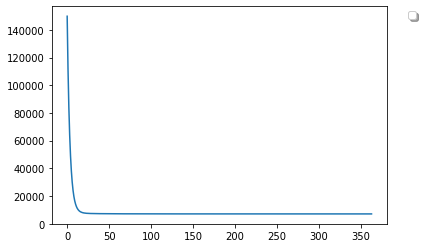

[22.74548023 -1.00695704  1.04172285  0.05071163  0.62307035 -1.86558657
  2.71080706 -0.28572203 -3.09874371  2.02599784 -1.80638574 -2.25793522
  0.58123396 -3.4382458 ]
RMSE
5.217879585785907
SSE
13536.65033589124


In [267]:
reg = LinearRegression(X, y, learningrate = 0.0004, maxIteration= 50000, epsilon = 0.005, gd = True, sgd = False, regularization=False, regparameter=100)
reg.fit()

solving using gradient descent with regularization


  0%|          | 72/50000 [00:00<00:03, 12586.58it/s]


Model Stopped Learning


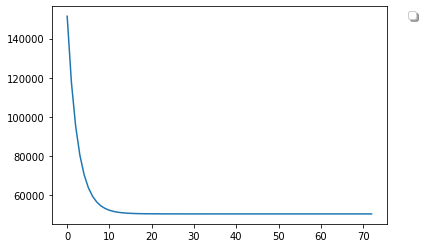

[17.7354547  -0.71410934  0.55453388 -0.46567416  0.67575561 -0.66237325
  2.68829094 -0.32533549 -1.40248472  0.28731253 -0.57221965 -1.83771423
  0.58369128 -2.59109523]
RMSE
7.5068734741920435
SSE
14348.477055418158


In [268]:
reg = LinearRegression(X, y, learningrate = 0.0004, maxIteration= 50000, epsilon = 0.005, gd = True, sgd = False, regularization=True, regparameter=100)
reg.fit()

solving using stochastic gradient descent


100%|██████████| 50000/50000 [00:03<00:00, 13609.83it/s]


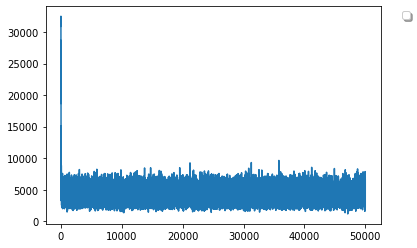

[ 2.28767902e+01 -8.74027554e-02 -7.29129374e-02 -6.16478585e-02
 -7.15418883e-02 -9.89449794e-03  3.04046224e-01 -7.03546947e-02
 -5.37045725e-02  3.64098252e-03  7.48802312e-03  8.01857768e-02
  1.15076838e-01 -2.57445165e-02]
RMSE
8.887169258745768
SSE
4992.9290791501


In [269]:
reg = LinearRegression(X, y, learningrate = 0.0004, maxIteration= 50000, epsilon = 0.005, gd = False, sgd = True, regularization=False, regparameter=100)
reg.fit()

solving using stochastic gradient descent


100%|██████████| 50000/50000 [00:04<00:00, 11401.29it/s]


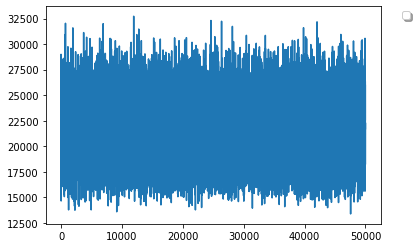

[ 7.58058381e+00 -2.22968848e-02 -7.68648936e-03  9.14778368e-02
  2.41060119e-01 -1.84816725e-01 -4.58968741e-02  8.44376900e-02
 -4.98542692e-02  8.04361837e-04 -1.51497415e-02 -4.01966590e-02
  5.89841358e-02  4.19132618e-02]
RMSE
17.0623667826383
SSE
31831.44624809417


In [279]:
reg = LinearRegression(X, y, learningrate = 0.0004, maxIteration= 50000, epsilon = 0.005, gd = False, sgd = True, regularization=True, regparameter=100)
reg.fit()

# Yacht Data

In [280]:
# Load CSV file into a numpy array
data = np.genfromtxt('yachtData.csv', delimiter=',')

# Display the shape of the array
print(data.shape)

(308, 7)


In [281]:
X = data[:,:-1]
y = data[:,-1]

In [282]:
reg = LinearRegression(X, y, learningrate = 0.001, maxIteration= 50000, epsilon = 0.001, gd = False, sgd = False, regularization=False, regparameter=100)
reg.fit()

Solving using normal equation
Normal Equation without Regularization
[11.23939535  0.81790302  0.20369276  2.97602416 -2.75890138 -3.83325201
 12.9328097 ]
RMSE
8.80194763079057
SSE
25185.91803691457


In [283]:
reg = LinearRegression(X, y, learningrate = 0.001, maxIteration= 50000, epsilon = 0.001, gd = False, sgd = False, regularization=True, regparameter=100)
reg.fit()

Solving using normal equation
Normal Equation with Regularization
[ 7.67133333  0.62686265 -0.45037461 -0.35431425 -0.10386047 -0.52005706
  8.83202127]
RMSE
8.836200337113878
SSE
20588.543793375095


solving using gradient descent


  3%|▎         | 1643/50000 [00:00<00:01, 28782.22it/s]


Model Stopped Learning


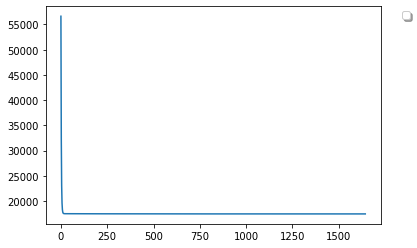

[11.23939535  0.81522178  0.13102656  2.68675502 -2.5228081  -3.55339498
 12.93260437]
RMSE
8.796248628280743
SSE
25177.824936215602


In [284]:
reg = LinearRegression(X, y, learningrate = 0.001, maxIteration= 50000, epsilon = 0.001, gd = True, sgd = False, regularization=False, regparameter=100)
reg.fit()

solving using gradient descent with regularization


  0%|          | 25/50000 [00:00<00:06, 7496.79it/s]


Model Stopped Learning


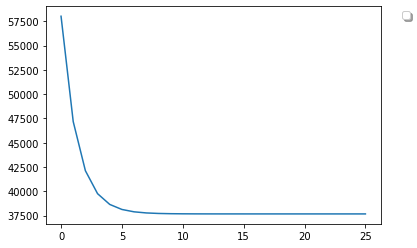

[ 7.67092329  0.62692391 -0.45112987 -0.35742824 -0.10138279 -0.51708504
  8.83153142]
RMSE
8.836370682060606
SSE
20588.228898766392


In [285]:
reg = LinearRegression(X, y, learningrate = 0.001, maxIteration= 50000, epsilon = 0.001, gd = True, sgd = False, regularization=True, regparameter=100)
reg.fit()

solving using stochastic gradient descent


100%|██████████| 50000/50000 [00:04<00:00, 12101.21it/s]


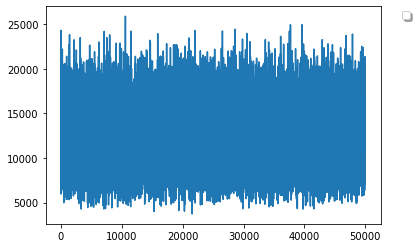

[11.47837137 -0.49158317  0.38449104  0.25433014  0.20386804 -0.32419032
  0.77659566]
RMSE
12.799103916536808
SSE
18839.48743369236


In [286]:
reg = LinearRegression(X, y, learningrate = 0.001, maxIteration= 50000, epsilon = 0.001, gd = False, sgd = True, regularization=False, regparameter=100)
reg.fit()

solving using stochastic gradient descent


100%|██████████| 50000/50000 [00:03<00:00, 12786.84it/s]


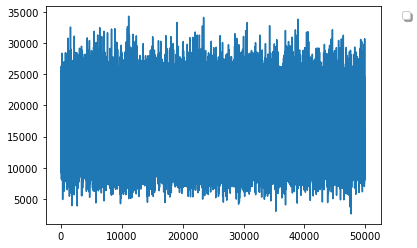

[ 3.60729034 -0.34603111 -0.05727368  0.31411656  0.36339504 -0.04173243
  0.46648814]
RMSE
13.75833610373298
SSE
21852.06260496215


In [288]:
reg = LinearRegression(X, y, learningrate = 0.001, maxIteration= 50000, epsilon = 0.001, gd = False, sgd = True, regularization=True, regparameter=100)
reg.fit()

# Concrete Data

In [290]:
# Load CSV file into a numpy array
data = np.genfromtxt('concreteData.csv', delimiter=',')

# Display the shape of the array
print(data.shape)

(1030, 9)


In [291]:
X = data[:,:-1]
y = data[:,-1]

In [292]:
reg = LinearRegression(X, y, learningrate = 0.0007, maxIteration= 50000, epsilon = 0.0001, gd = False, sgd = False, regularization=False, regparameter=100)
reg.fit()

Solving using normal equation
Normal Equation without Regularization
[35.85368932 12.72547471  9.54463305  5.99752761 -2.82130272  2.10540297
  1.85195151  1.95023318  7.17433735]
RMSE
9.67567754660951
SSE
179408.9985580014


In [293]:
reg = LinearRegression(X, y, learningrate = 0.001, maxIteration= 50000, epsilon = 0.001, gd = False, sgd = False, regularization=True, regparameter=100)
reg.fit()

Solving using normal equation
Normal Equation with Regularization
[31.48661389  6.96527588  3.90534525  0.93315229 -4.69943377  2.8806971
 -1.11414466 -2.0182032   5.91158313]
RMSE
11.111969956642456
SSE
188672.5826258105


solving using gradient descent


  1%|          | 264/50000 [00:00<00:15, 3109.60it/s]

Model Stopped Learning


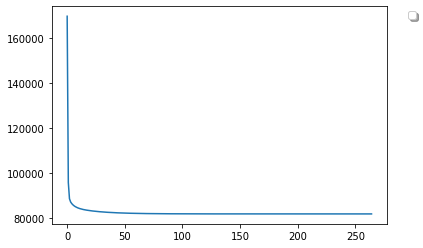

[35.85368932 12.71190286  9.53101788  5.98553758 -2.83291958  2.10379621
  1.84122771  1.93695188  7.17397436]
RMSE
9.675382207038489
SSE
179398.94319358695


In [294]:
reg = LinearRegression(X, y, learningrate = 0.001, maxIteration= 50000, epsilon = 0.001, gd = True, sgd = False, regularization=False, regparameter=100)
reg.fit()

solving using gradient descent with regularization


  0%|          | 46/50000 [00:00<00:04, 10842.87it/s]


Model Stopped Learning


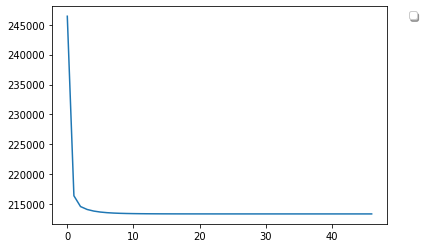

[31.48661389  6.96303396  3.90309616  0.93116932 -4.7013417   2.88044227
 -1.11590985 -2.02039306  5.91152223]
RMSE
11.112015919707876
SSE
188671.5124194882


In [295]:
reg = LinearRegression(X, y, learningrate = 0.001, maxIteration= 50000, epsilon = 0.001, gd = True, sgd = False, regularization=True, regparameter=100)
reg.fit()

solving using stochastic gradient descent


100%|██████████| 50000/50000 [00:04<00:00, 10904.06it/s]


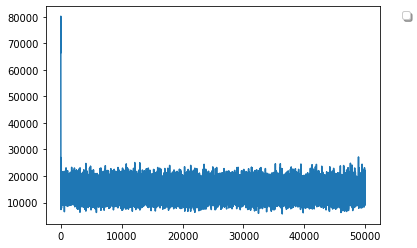

[36.26581239 -0.30367485  0.18589247  0.15152398  0.24036061  0.50612689
  0.8530236  -0.67967149  0.28429622]
RMSE
16.05378119267588
SSE
110291.72699744318


In [296]:
reg = LinearRegression(X, y, learningrate = 0.001, maxIteration= 50000, epsilon = 0.001, gd = False, sgd = True, regularization=False, regparameter=100)
reg.fit()

solving using stochastic gradient descent


100%|██████████| 50000/50000 [00:05<00:00, 9934.69it/s] 


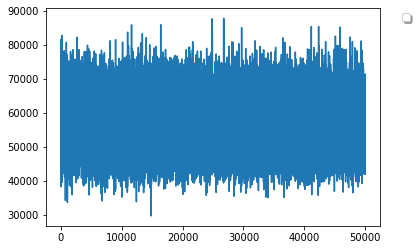

[ 1.22179475e+01 -3.96722677e-01  3.40887726e-04  1.65200137e-01
 -1.35026481e-01  1.90057206e-01 -1.00917402e-02  1.38308626e-01
  2.33572290e-02]
RMSE
28.566161764412463
SSE
382040.47953240137


In [297]:
reg = LinearRegression(X, y, learningrate = 0.001, maxIteration= 50000, epsilon = 0.001, gd = False, sgd = True, regularization=True, regparameter=100)
reg.fit()

We can observe that increasing the learning rate leads to faster convergence of the model. However, this comes at the cost of longer waiting time and a negative impact on its performance due to slower learning rate.

Similarly, we have noticed that raising the Regularization Parameter results in a decrease in the RSME value. Regularization leads to a lower Theta value than usual, which helps in avoiding over- and under-fitting.